In [1]:
from libtiff import TIFF
from matplotlib import pyplot as plt
import numpy as np

In [26]:
# 给的tiff是奇怪的shape，需要转换
tif = TIFF.open("../res/v2/ElectricityProjectClassificationResult_v2.tif", mode='r')  # 打開tiff文件進行讀取

NameError: name 'TIFF' is not defined

In [18]:
im = tif.read_image()

In [19]:
im.shape

(3, 8100, 10470)

In [20]:
img = np.dstack((im[0], im[1]))
img = np.dstack((img, im[2]))

In [21]:
img.shape

(8100, 10470, 3)

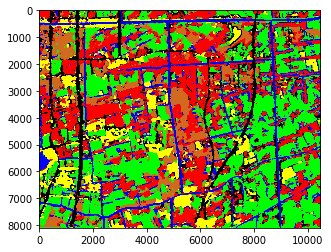

In [22]:
plt.imshow(img)

## 地理信息提取

In [23]:
import rasterio

In [24]:
fp = r'../res/v2/ElectricityProjectClassificationResult_v2.tif'
geoinf = rasterio.open(fp)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [25]:
geoinf.scales

(1.0, 1.0, 1.0)

### 查看六种地类对应的颜色值

In [26]:
tmp_img = img[0:1000,0:1000,:]

In [32]:
tmp_img

array([[[  0, 255,   2],
        [  1, 254,   2],
        [  4, 252,   3],
        ...,
        [248,   2,   0],
        [247,   2,   0],
        [247,   2,   0]],

       [[  0, 254,   2],
        [  1, 253,   2],
        [  5, 252,   3],
        ...,
        [248,   2,   0],
        [247,   2,   0],
        [247,   2,   0]],

       [[  2, 253,   2],
        [  4, 252,   3],
        [  7, 250,   4],
        ...,
        [248,   2,   0],
        [247,   2,   0],
        [247,   2,   0]],

       ...,

       [[  0,   0, 252],
        [  0,   0, 252],
        [  0,   0, 252],
        ...,
        [211, 105,  31],
        [211, 105,  31],
        [211, 105,  31]],

       [[  0,   0, 252],
        [  0,   0, 252],
        [  0,   0, 252],
        ...,
        [211, 105,  31],
        [211, 105,  31],
        [211, 105,  31]],

       [[  0,   0, 252],
        [  0,   0, 252],
        [  0,   0, 252],
        ...,
        [211, 105,  31],
        [211, 105,  31],
        [211, 105,  31]]

In [43]:
color_set = set()
for row in range(10):
    for col in range(10):
        [r,g,b] = img[row,col]
        color_set.add((r,g,b))

In [44]:
len(color_set)

94

In [48]:
[r,g,b]=img[0,0]

In [54]:
a=set()
a.add((1,2,3))
a.add((1,2,3))
a.add((12,2,3))

In [55]:
a

{(1, 2, 3), (12, 2, 3)}

In [45]:
len(color_set)

94

### 从v3文件中提取路线

In [2]:
from osgeo import ogr
import cv2

In [43]:
from osgeo import gdal
from osgeo import osr
import os
import numpy as np

In [4]:
driver = ogr.GetDriverByName("ESRI Shapefile") 

filename = "../res/v4/Road_vector/Road_v2.shp"

dataSource = driver.Open(filename, 0)

layer = dataSource.GetLayer(0)

In [5]:
layer.GetExtent()

(0.32430483500464863,
 10470.65350339356,
 -1.9550746191193986,
 8104.697239890489)

In [8]:
def coordinate_transfer(old_x,old_y,layer_shape, sketch_shape):
    width = layer_shape[1]-layer_shape[0]
    height = layer_shape[3]-layer_shape[2]
    new_x = round((old_x-layer_shape[0])/width*sketch_shape[0])
    new_y = round((old_y-layer_shape[2])/height*sketch_shape[1])
    return new_x, new_y

In [67]:
def road_extract(layer):
    line_list=[]
    layer_shape = layer.GetExtent()
    for i in range(0,layer.GetFeatureCount()):
        feat = layer.GetFeature(i)
        geom = feat.geometry()
        if geom is None:
            continue
        line=[]
        if geom.GetGeometryCount()>0:
            for j in range(0, geom.GetGeometryCount()):
                g = feat.geometry().GetGeometryRef(j)
                for p in range(0, g.GetPointCount()):
                    pt=g.GetPoint(p)
#                     new_x,new_y=coordinate_transfer(pt[0],pt[1],layer_shape, sketch_shape)
#                     line.append((new_x,new_y))
                    line.append((round(pt[0]),8100-round(pt[1])))
        else:
            for p in range(0, geom.GetPointCount()):
                pt=geom.GetPoint(p)
#                 new_x,new_y=coordinate_transfer(pt[0],pt[1],layer_shape, sketch_shape)
#                 line.append((new_x,new_y))
                line.append((round(pt[0]),8100-round(pt[1])))
        line_list.append(line)
    return line_list

In [36]:
def getSRSPair(prj):
    '''
    获得给定数据的投影参考系和地理参考系
    :param dataset: GDAL地理数据
    :return: 投影参考系和地理参考系
    '''
    prosrs = osr.SpatialReference()
    prosrs.ImportFromWkt(prj)
    geosrs = prosrs.CloneGeogCS()
    return prosrs, geosrs

In [37]:
def geo2lonlat(prj, x, y):
    '''
    将投影坐标转为经纬度坐标（具体的投影坐标系由给定数据确定）
    :param dataset: GDAL地理数据
    :param x: 投影坐标x
    :param y: 投影坐标y
    :return: 投影坐标(x, y)对应的经纬度坐标(lon, lat)
    '''
    prosrs, geosrs = getSRSPair(prj)
    ct = osr.CoordinateTransformation(prosrs, geosrs)
    coords = ct.TransformPoint(x, y)
    return coords[:2]

In [68]:
roads=road_extract(layer)

In [69]:
roads[0][0]

(431, -5)

In [76]:
background=np.zeros((8100,10470),dtype=np.uint8)

In [77]:
for path in roads:
    p1 = path[0]
    for index, p in enumerate(path):
        if index == 0:
            continue
        p2 = p
        cv2.line(background, p1, p2, (255, 0, 0), 30)
        p1 = p

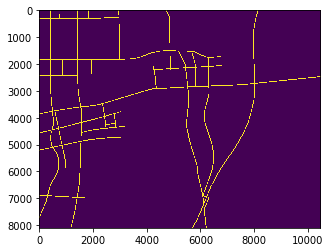

In [78]:
plt.imshow(background)

## 小测试，用极坐标采样邻居节点

In [ ]:
def neighbors_generator(radius_inner, radius_outer, sample_n):
    quadrant = []
    result = set()
    for x in range(0, radius_outer + 1):
        for y in range(0, radius_outer + 1):
            if radius_inner ** 2 <= x ** 2 + y ** 2 <= radius_outer ** 2:
                if x % sample_n == 0 and y % sample_n == 0:
                    quadrant.append((x, y))

    for x, y in quadrant:
        result.add((x, y))
        result.add((-x, y))
        result.add((x, -y))
        result.add((-x, -y))
    return list(result)

In [178]:
import random
import numpy as np

In [193]:
def neighbors_generator(radius_inner, radius_outer, sample_n):
    result=set()
    for _ in range(sample_n):
        degree = random.uniform(0,360)/180*np.pi
        length = random.uniform(radius_inner,radius_outer)
        x=round(np.cos(degree)*length)
        y=round(np.sin(degree)*length)
        result.add((x,y))
    return list(result)

In [194]:
neighbors_generator(300,350,10)

[(77, 312),
 (-327, -109),
 (-336, 23),
 (240, 192),
 (201, 273),
 (314, 4),
 (-312, -153),
 (33, 331),
 (292, 97),
 (-263, -169)]